In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.decomposition import PCA, SparsePCA
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

DATAPATH = "~/Vaughan/datasets/stressrecov"

In [2]:
daily_merged = pd.read_parquet("~/stressrecovery/data/processed/survey/daily_merged.parquet")

In [3]:
daily_merged["covid_shift_any"] = daily_merged.apply (lambda row: (row.daily_covid_shifts___1 or row.daily_covid_shifts___2 or row.daily_covid_shifts___3 ), axis=1)

In [4]:
daily_merged[daily_merged["date"].isna()]

,participant_id,record_id_x,redcap_repeat_instrument_x,redcap_repeat_instance_x,daily_stressed,daily_timing___1,daily_timing___2,daily_timing___3,daily_timing___4,daily_timing___5,daily_duration,daily_control,daily_cause,daily_5a,daily_reduce,daily_6a,daily_shifts,daily_covid_shifts___1,daily_covid_shifts___2,daily_covid_shifts___3,daily_arrive,daily_leave,daily_ts,daily858_uuid,daily858_startdate,daily858_enddate,daily858_scheduledate,daily858_status,daily858_serializedresult,daily_stress_measure_complete,date,record_id_y,redcap_repeat_instrument_y,redcap_repeat_instance_y,ema_1,ema_2,ema_ts,cou_uuid,cou_startdate,cou_enddate,cou_scheduledate,cou_status,cou_serializedresult,cough_ema_complete,work24,sam1,sam2,sam3,sam4,sam5,sam6,sam7,sam8,sam_ts,sam944_uuid,sam944_startdate,sam944_enddate,sam944_scheduledate,sam944_status,sam944_serializedresult,selfassessment_mannequin_sam_complete,ppe_change,covid_past_24,ppe_2,ppe_3,ppe_4,ppe_5,ppe_6,ppe_ts,ppe_uuid,ppe_startdate,ppe_enddate,ppe_scheduledate,ppe_status,ppe_serializedresult,ppe_and_exposure_scale_complete,covid_shift_any


In [5]:
daily_merged.isna().sum()

participant_id                               0
record_id_x                                113
redcap_repeat_instrument_x                 113
redcap_repeat_instance_x                   113
daily_stressed                             113
daily_timing___1                           113
daily_timing___2                           113
daily_timing___3                           113
daily_timing___4                           113
daily_timing___5                           113
daily_duration                           19091
daily_control                            19091
daily_cause                              19091
daily_5a                                 23356
daily_reduce                             19091
daily_6a                                 22367
daily_shifts                               113
daily_covid_shifts___1                     113
daily_covid_shifts___2                     113
daily_covid_shifts___3                     113
daily_arrive                             13669
daily_leave  

In [6]:
#Loop through
#For each participant, sorted by date
#Nested dictionary of {participant: {measure: array, measure: array,...}}
#Measures: daily_stressed, daily_shifts, covid_shift_any

participant_dict = {}
for participant in daily_merged.participant_id.unique():
    participant_dict[participant] = {"date":[],"daily_stressed":[],"daily_shifts":[], "covid_shift_any":[]}
    
for key, value in participant_dict.items():
    df = daily_merged.loc[daily_merged["participant_id"] == key]
    df = df.sort_values(by=['date'])
    
    first_date = df.date.min()
    last_date = df.date.max()
    
    date_range = pd.date_range(start=first_date,end=last_date)
    date_range = [i.to_pydatetime().date() for i in date_range]
    
    participant_dict[key]["date"] = date_range
    for day in date_range:
        try:
            participant_dict[key]["daily_stressed"].append(
                df.loc[df['date'] == day, 'daily_stressed'].iloc[0])

        except IndexError:
            participant_dict[key]["daily_stressed"].append(np.nan)

        try:
            participant_dict[key]["daily_shifts"].append(
                df.loc[df['date'] == day, 'daily_shifts'].iloc[0])

        except IndexError:
            participant_dict[key]["daily_shifts"].append(np.nan)

        try:
            participant_dict[key]["covid_shift_any"].append(
                df.loc[df['date'] == day, 'covid_shift_any'].iloc[0])

        except IndexError:
            participant_dict[key]["covid_shift_any"].append(np.nan)

    
    ##SKIPPED DAYS GET NAN

In [7]:
days_observed=[]
for key, value in participant_dict.items():
    days_observed.append(len(participant_dict[key]["date"]))

/h/snagaraj/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


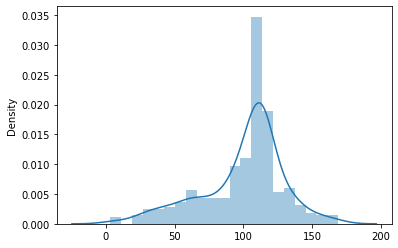

In [8]:
sns.distplot(days_observed, norm_hist=True)

In [9]:
#Maybe just patients with at least 100 days?
#Downsampling? Or just Truncating?
#Treat NaNs as relevant information? recode as -1

In [10]:
import math
def recode_nan(lis):
    return [-1.0 if math.isnan(x) else x for x in lis]

In [11]:
#RECODING NANS

for key, value in participant_dict.items():
    participant_dict[key]["daily_stressed"] = recode_nan(participant_dict[key]["daily_stressed"])
    participant_dict[key]["daily_shifts"] = recode_nan(participant_dict[key]["daily_shifts"])
    participant_dict[key]["covid_shift_any"] = recode_nan(participant_dict[key]["covid_shift_any"])

In [12]:
#DISTANCE METRICS
from scipy.spatial.distance import hamming

# Function to calculate Chi-distace 
def chi2_distance(A, B): 
    # compute the chi-squared distance using above formula 
    chi = 0.5 * np.sum([((a - b) ** 2) / (a + b)  
                      for (a, b) in zip(A, B)]) 
    return chi 

#define Jaccard Similarity function
def jaccard_sim(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

def jaccard_dist(list1,list2):
    sim = jaccard_sim(list1,list2)
    return (1-sim)

def levenshteinDistanceDP(token1, token2):
    distances = np.zeros((len(token1) + 1, len(token2) + 1))

    for t1 in range(len(token1) + 1):
        distances[t1][0] = t1

    for t2 in range(len(token2) + 1):
        distances[0][t2] = t2
        
    a = 0
    b = 0
    c = 0
    
    for t1 in range(1, len(token1) + 1):
        for t2 in range(1, len(token2) + 1):
            if (token1[t1-1] == token2[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]
                
                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1

    return distances[len(token1)][len(token2)]

In [13]:
daily_merged.participant_id.unique()

array(['U-5C245D4USLA4KUFTXP4F', 'U-F9VXYTCH72BDQRL1P362',
       'U-57UM19XV2DHKDSTCEAW3', 'U-WCP51H4RJ34PTJZZ4LFF',
       'U-UU3LBKS5HVAXUU3X8WPR', 'U-1AFJWXDX3WVA8ZEMEL35',
       'U-SKXE6RDVNM9NPUSS313H', 'U-YMN83HU69YYBG8SACEZR',
       'U-7X1E3WVP1STH4K3V8YN3', 'U-8P78DY5MFA29Y9Z28GCR',
       'U-L9892JV7T3CV9WQQW556', 'U-BS81FL8VF39LW13U9AGK',
       'U-TXUKC7KJX7SHVM87FCHV', 'U-11YJYE852QXSR8AUC2W1',
       'U-EAEMP99UXB4H1VBXRGVK', 'U-6RBP3SMX16NXKX4KR6ND',
       'U-GLWWU7417B1G79ZQH56V', 'U-QS116SV8R8D89Y6M13RX',
       'U-SKA1R9TM31B19XL9MG51', 'U-HMS81C96UB7MPJJ4CSTH',
       'U-1DV1Y8WJ5MD3WEFER4M8', 'U-ATEES286BB2TCX95R9T3',
       'U-C3YUMHF66UMWMCWJ6XL7', 'U-1M1PWFRM99UKVZBE4JN8',
       'U-5TGWTDR5XV27ZZR536ZT', 'U-5LL4T2VTY2XQVDZPZN9D',
       'U-37WY5HKXCGCB5HRSR9QJ', 'U-7N4QAAKGRRXGV7V66NSG',
       'U-4XL6UCYA87SVGD6Q51CQ', 'U-A64UMSKP4VKY12R3MPKD',
       'U-AX5N47KSTGK56XY4XW47', 'U-2MZ8BD4K1XGRSRYMBZD6',
       'U-78W128SEFL92J9DGKNDU', 'U-TQXU1XRNJKWFMXGR7X89

In [14]:
participant_dict['U-5C245D4USLA4KUFTXP4F']["daily_shifts"]

[0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 -1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 -1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 0.0,
 -1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 -1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 -1.0,
 -1.0,
 0.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 0.0,
 1.0]

In [15]:
len(participant_dict['U-57UM19XV2DHKDSTCEAW3']["daily_stressed"])

101

In [16]:
levenshteinDistanceDP(participant_dict['U-5C245D4USLA4KUFTXP4F']["daily_stressed"],participant_dict['U-57UM19XV2DHKDSTCEAW3']["daily_stressed"] )

80.0

In [17]:
jaccard_dist(participant_dict['U-5C245D4USLA4KUFTXP4F']["daily_stressed"],participant_dict['U-57UM19XV2DHKDSTCEAW3']["daily_stressed"] )

0.9885057471264368

In [18]:
#JACCARD AND LEVENSHTEIN WORK FOR DIFF LENGTHS
#CHI2 and Hamming does NOT


# Similarity Network Fusion

In [19]:
#Generate Distance matrices at patient-level for each measure using several distance metrics

#First-start with only patients with at least 100days observed, and slice for 100days so they're all same length


#Convert distance matrices to affinity matrices

In [20]:
#function to generate array of observation based on specific expected length

def observation_truncate(participant_dict, length, option="first"):
    participant_lis=[]
    stress_array=[]
    shifts_array=[]
    covid_array=[]
    for key,value in participant_dict.items():
        if len(participant_dict[key]["date"])>length:
            participant_lis.append(key)
            
            if option=="last": 
                stress_array.append(participant_dict[key]["daily_stressed"][-length:])
                shifts_array.append(participant_dict[key]["daily_shifts"][-length:])
                covid_array.append(participant_dict[key]["covid_shift_any"][-length:])
            else:
                stress_array.append(participant_dict[key]["daily_stressed"][:length])
                shifts_array.append(participant_dict[key]["daily_shifts"][:length])
                covid_array.append(participant_dict[key]["covid_shift_any"][:length])
                
        elif len(participant_dict[key]["date"])==length:
            participant_lis.append(key)
            stress_array.append(participant_dict[key]["daily_stressed"])
            shifts_array.append(participant_dict[key]["daily_shifts"])
            covid_array.append(participant_dict[key]["covid_shift_any"])
    
    return np.array(participant_lis), np.array([np.array(i) for i in stress_array]), np.array([np.array(i) for i in shifts_array]), np.array([np.array(i) for i in covid_array])
            

In [21]:
participant, stress, shifts, covid = observation_truncate(participant_dict, 100, option="last")

In [22]:
from sklearn.metrics import pairwise_distances

#Generate Distance matrices at patient-level for each measure using several distance metrics

stress_dist_lev = pairwise_distances(stress, metric=levenshteinDistanceDP)
shifts_dist_lev = pairwise_distances(shifts, metric=levenshteinDistanceDP)
covid_dist_lev = pairwise_distances(covid, metric=levenshteinDistanceDP)

In [23]:
df = pd.DataFrame([participant, stress, shifts, covid])
df = df.transpose()
df.columns = ['participant_id', 'stress', "shifts","covid"]
df

,participant_id,stress,shifts,covid
0,U-5C245D4USLA4KUFTXP4F,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, ..."
1,U-57UM19XV2DHKDSTCEAW3,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
2,U-WCP51H4RJ34PTJZZ4LFF,"[0.0, 0.0, 0.0, 0.0, 1.0, -1.0, 0.0, 0.0, 0.0,...","[1.0, 1.0, 1.0, 0.0, 1.0, -1.0, 0.0, 0.0, 1.0,...","[1.0, 1.0, 1.0, 0.0, 1.0, -1.0, 0.0, 0.0, 1.0,..."
3,U-UU3LBKS5HVAXUU3X8WPR,"[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
4,U-SKXE6RDVNM9NPUSS313H,"[0.0, -1.0, 0.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0....","[0.0, -1.0, 1.0, -1.0, -1.0, 1.0, 0.0, 0.0, 1....","[0.0, -1.0, 1.0, -1.0, -1.0, 1.0, 0.0, 0.0, 1...."
5,U-BS81FL8VF39LW13U9AGK,"[1.0, 1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
6,U-TXUKC7KJX7SHVM87FCHV,"[0.0, 0.0, 0.0, -1.0, -1.0, 1.0, 0.0, 0.0, 0.0...","[1.0, 0.0, 0.0, -1.0, -1.0, 1.0, 0.0, 1.0, 0.0...","[1.0, 0.0, 0.0, -1.0, -1.0, 1.0, 0.0, 1.0, 0.0..."
7,U-11YJYE852QXSR8AUC2W1,"[0.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0,...","[1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0,...","[1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0,..."
8,U-QS116SV8R8D89Y6M13RX,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
9,U-SKA1R9TM31B19XL9MG51,"[0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0...","[0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0...","[0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0..."


In [24]:
df["stress_-1"]=  df.apply (lambda row: (row.stress == -1.0).sum(), axis=1)
df["stress_0"]=  df.apply (lambda row: (row.stress == 0.0).sum(), axis=1)
df["stress_1"]=  df.apply (lambda row: (row.stress == 1.0).sum(), axis=1)

df["shifts_-1"]=  df.apply (lambda row: (row.shifts == -1.0).sum(), axis=1)
df["shifts_0"]=  df.apply (lambda row: (row.shifts == 0.0).sum(), axis=1)
df["shifts_1"]=  df.apply (lambda row: (row.shifts == 1.0).sum(), axis=1)

df["covid_-1"]=  df.apply (lambda row: (row.covid == -1.0).sum(), axis=1)
df["covid_0"]=  df.apply (lambda row: (row.covid == 0.0).sum(), axis=1)
df["covid_1"]=  df.apply (lambda row: (row.covid == 1.0).sum(), axis=1)

df

,participant_id,stress,shifts,covid,stress_-1,stress_0,stress_1,shifts_-1,shifts_0,shifts_1,covid_-1,covid_0,covid_1
0,U-5C245D4USLA4KUFTXP4F,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...",11,67,22,11,35,54,11,35,54
1,U-57UM19XV2DHKDSTCEAW3,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",25,61,14,25,46,29,25,46,29
2,U-WCP51H4RJ34PTJZZ4LFF,"[0.0, 0.0, 0.0, 0.0, 1.0, -1.0, 0.0, 0.0, 0.0,...","[1.0, 1.0, 1.0, 0.0, 1.0, -1.0, 0.0, 0.0, 1.0,...","[1.0, 1.0, 1.0, 0.0, 1.0, -1.0, 0.0, 0.0, 1.0,...",18,66,16,18,49,25,18,49,33
3,U-UU3LBKS5HVAXUU3X8WPR,"[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",5,88,7,5,48,47,5,48,47
4,U-SKXE6RDVNM9NPUSS313H,"[0.0, -1.0, 0.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0....","[0.0, -1.0, 1.0, -1.0, -1.0, 1.0, 0.0, 0.0, 1....","[0.0, -1.0, 1.0, -1.0, -1.0, 1.0, 0.0, 0.0, 1....",42,41,17,42,23,34,42,23,35
5,U-BS81FL8VF39LW13U9AGK,"[1.0, 1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",25,70,5,25,42,33,25,42,33
6,U-TXUKC7KJX7SHVM87FCHV,"[0.0, 0.0, 0.0, -1.0, -1.0, 1.0, 0.0, 0.0, 0.0...","[1.0, 0.0, 0.0, -1.0, -1.0, 1.0, 0.0, 1.0, 0.0...","[1.0, 0.0, 0.0, -1.0, -1.0, 1.0, 0.0, 1.0, 0.0...",26,50,24,26,45,29,26,45,29
7,U-11YJYE852QXSR8AUC2W1,"[0.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0,...","[1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0,...","[1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0,...",47,49,4,47,32,21,47,32,21
8,U-QS116SV8R8D89Y6M13RX,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",15,30,55,15,55,30,15,55,30
9,U-SKA1R9TM31B19XL9MG51,"[0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0...","[0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0...","[0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0...",74,18,8,74,14,12,74,14,12


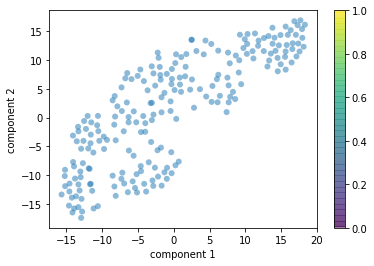

In [25]:
pipeline = Pipeline([#('scaling', Normalizer()), 
                     ('pca', TSNE(n_components=2))])

projected=pipeline.fit_transform(stress_dist_lev)

plt.scatter(projected[:,0], projected[:, 1],
            #c=range(len(w_distance_matrix)),
             edgecolor='none', alpha=0.5,
            #cmap=plt.cm.get_cmap('RdBu', 300)
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

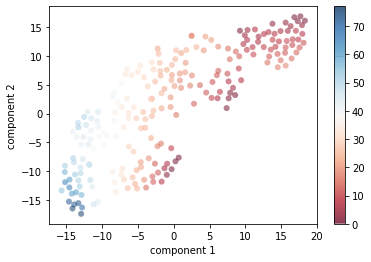

In [26]:
plt.scatter(projected[:,0], projected[:, 1],
            c=df["stress_-1"].values,
             edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('RdBu', 219)
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

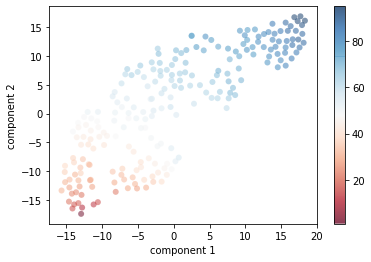

In [27]:
plt.scatter(projected[:,0], projected[:, 1],
            c=df["stress_0"].values,
             edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('RdBu', 219)
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

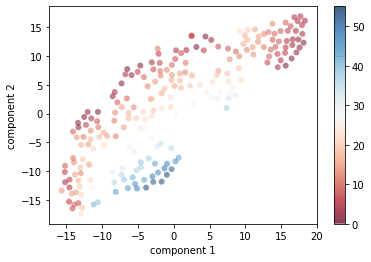

In [28]:
plt.scatter(projected[:,0], projected[:, 1],
            c=df["stress_1"].values,
             edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('RdBu', 219)
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

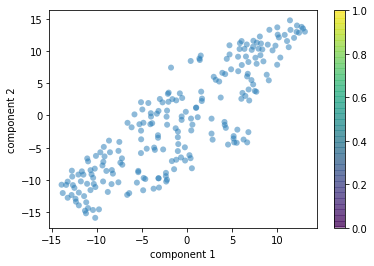

In [29]:
pipeline = Pipeline([#('scaling', Normalizer()), 
                     ('pca', TSNE(n_components=2))])

projected=pipeline.fit_transform(shifts_dist_lev)

plt.scatter(projected[:,0], projected[:, 1],
            #c=range(len(w_distance_matrix)),
             edgecolor='none', alpha=0.5,
            #cmap=plt.cm.get_cmap('RdBu', 300)
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

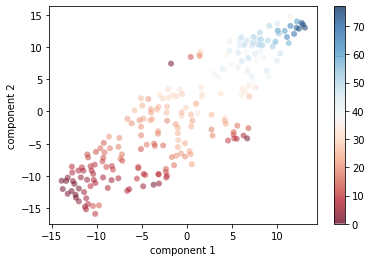

In [30]:
plt.scatter(projected[:,0], projected[:, 1],
            c=df["shifts_-1"].values,
             edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('RdBu', 219)
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

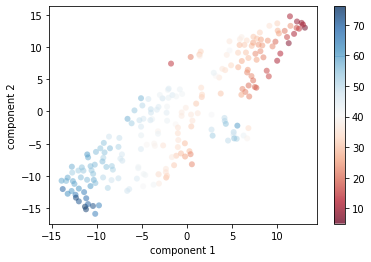

In [31]:
plt.scatter(projected[:,0], projected[:, 1],
            c=df["shifts_0"].values,
             edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('RdBu', 219)
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

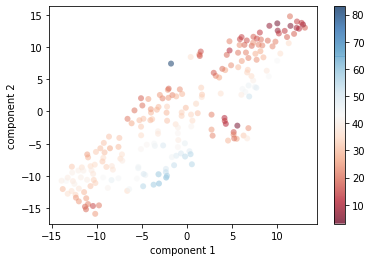

In [32]:
plt.scatter(projected[:,0], projected[:, 1],
            c=df["shifts_1"].values,
             edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('RdBu', 219)
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

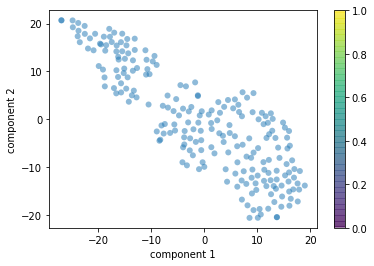

In [33]:
pipeline = Pipeline([#('scaling', Normalizer()), 
                     ('pca', TSNE(n_components=2))])

projected=pipeline.fit_transform(covid_dist_lev)

plt.scatter(projected[:,0], projected[:, 1],
            #c=range(len(w_distance_matrix)),
             edgecolor='none', alpha=0.5,
            #cmap=plt.cm.get_cmap('RdBu', 300)
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

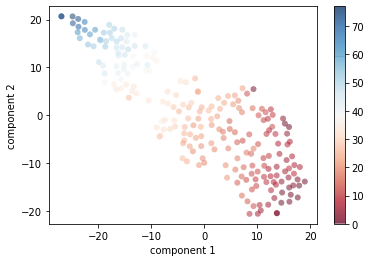

In [34]:
plt.scatter(projected[:,0], projected[:, 1],
            c=df["covid_-1"].values,
             edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('RdBu', 219)
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

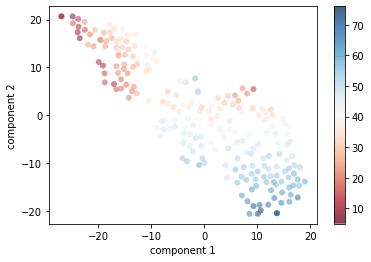

In [35]:
plt.scatter(projected[:,0], projected[:, 1],
            c=df["covid_0"].values,
             edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('RdBu', 219)
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

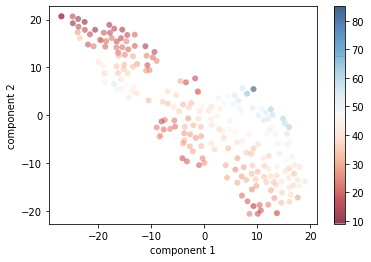

In [36]:
plt.scatter(projected[:,0], projected[:, 1],
            c=df["covid_1"].values,
             edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('RdBu', 219)
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [37]:
import snf
from snf import compute

In [38]:
stress_affinity_lev = compute.affinity_matrix(stress_dist_lev)
shifts_affinity_lev = compute.affinity_matrix(shifts_dist_lev)
covid_affinity_lev = compute.affinity_matrix(covid_dist_lev)


In [39]:
fused = compute.snf([stress_affinity_lev, shifts_affinity_lev, covid_affinity_lev], K=25)

In [40]:
np.shape(fused)

(219, 219)

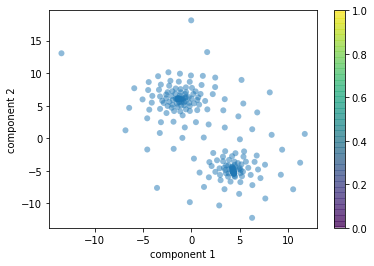

In [41]:
pipeline = Pipeline([#('scaling', Normalizer()), 
                     ('pca', TSNE(n_components=2))])

projected=pipeline.fit_transform(fused)

plt.scatter(projected[:,0], projected[:, 1],
            #c=range(len(w_distance_matrix)),
             edgecolor='none', alpha=0.5,
            #cmap=plt.cm.get_cmap('RdBu', 300)
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

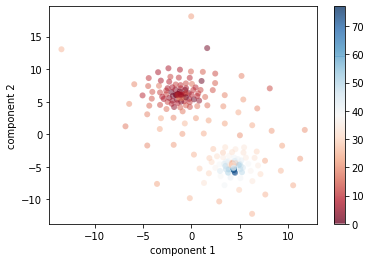

In [42]:
plt.scatter(projected[:,0], projected[:, 1],
            c=df["stress_-1"].values,
             edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('RdBu', 219)
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

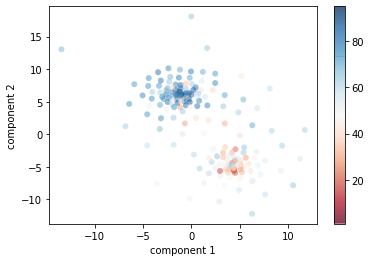

In [43]:
plt.scatter(projected[:,0], projected[:, 1],
            c=df["stress_0"].values,
             edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('RdBu', 219)
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

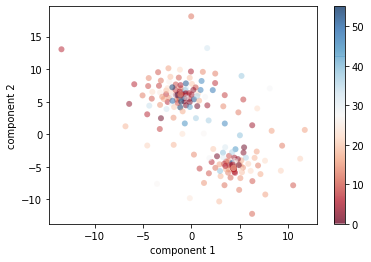

In [44]:
plt.scatter(projected[:,0], projected[:, 1],
            c=df["stress_1"].values,
             edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('RdBu', 219)
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

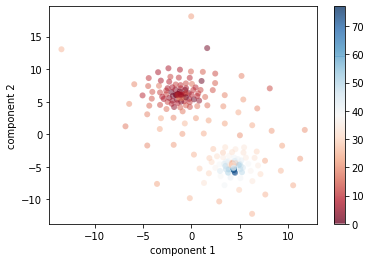

In [45]:
plt.scatter(projected[:,0], projected[:, 1],
            c=df["shifts_-1"].values,
             edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('RdBu', 219)
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

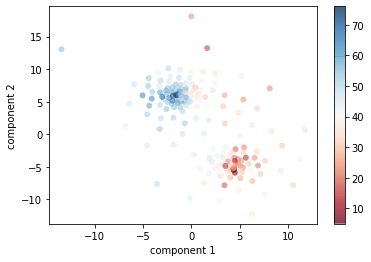

In [46]:
plt.scatter(projected[:,0], projected[:, 1],
            c=df["]\].values,
             edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('RdBu', 219)
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

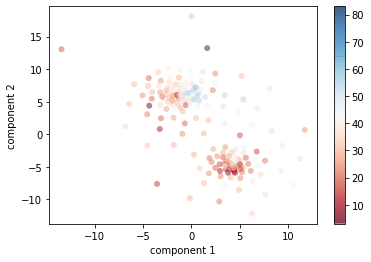

In [47]:
plt.scatter(projected[:,0], projected[:, 1],
            c=df["shifts_1"].values,
             edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('RdBu', 219)
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

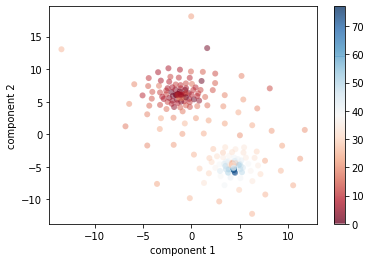

In [48]:
plt.scatter(projected[:,0], projected[:, 1],
            c=df["covid_-1"].values,
             edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('RdBu', 219)
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

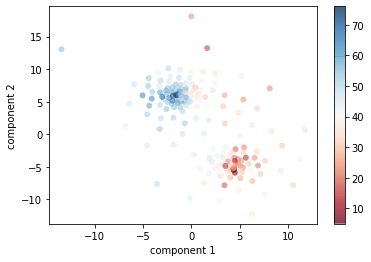

In [49]:
plt.scatter(projected[:,0], projected[:, 1],
            c=df["shifts_0"].values,
             edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('RdBu', 219)
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

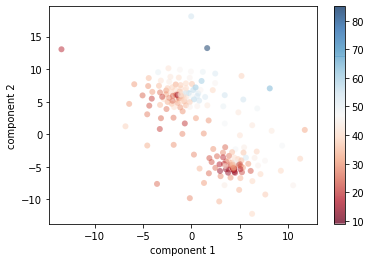

In [50]:
plt.scatter(projected[:,0], projected[:, 1],
            c=df["covid_1"].values,
             edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('RdBu', 219)
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [51]:
first, second = compute.get_n_clusters(fused)
first

2

In [52]:
from sklearn import cluster
fused_labels = cluster.spectral_clustering(fused, n_clusters=first)

In [53]:
np.unique(fused_labels, return_counts=True)

(array([0, 1], dtype=int32), array([ 84, 135]))

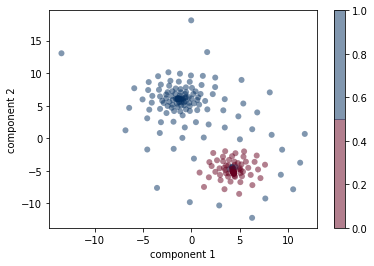

In [54]:
plt.scatter(projected[:,0], projected[:, 1],
            c=fused_labels,
             edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('RdBu', 2)
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [55]:
participant

array(['U-5C245D4USLA4KUFTXP4F', 'U-57UM19XV2DHKDSTCEAW3',
       'U-WCP51H4RJ34PTJZZ4LFF', 'U-UU3LBKS5HVAXUU3X8WPR',
       'U-SKXE6RDVNM9NPUSS313H', 'U-BS81FL8VF39LW13U9AGK',
       'U-TXUKC7KJX7SHVM87FCHV', 'U-11YJYE852QXSR8AUC2W1',
       'U-QS116SV8R8D89Y6M13RX', 'U-SKA1R9TM31B19XL9MG51',
       'U-HMS81C96UB7MPJJ4CSTH', 'U-1DV1Y8WJ5MD3WEFER4M8',
       'U-ATEES286BB2TCX95R9T3', 'U-C3YUMHF66UMWMCWJ6XL7',
       'U-1M1PWFRM99UKVZBE4JN8', 'U-5TGWTDR5XV27ZZR536ZT',
       'U-5LL4T2VTY2XQVDZPZN9D', 'U-7N4QAAKGRRXGV7V66NSG',
       'U-4XL6UCYA87SVGD6Q51CQ', 'U-AX5N47KSTGK56XY4XW47',
       'U-2MZ8BD4K1XGRSRYMBZD6', 'U-78W128SEFL92J9DGKNDU',
       'U-9J5AJPVS8QB6PNACGXRC', 'U-5K9GSVTNZMKVGG9USNAU',
       'U-DSB4GHYGHXU8FGABKEWB', 'U-TA9DZH13P9C7LWU9DRTN',
       'U-KJJGFNVCALZ45EX3MQV5', 'U-YQEHZM1ZP3XCSHVBP11V',
       'U-XZ7U958ZLVPHTUVFSZW7', 'U-D8NNJ5Z84SDXV2QEZZ5V',
       'U-W41B6L41VS1LGYMNPRCU', 'U-JPDNH3HHBQRJ9SGFPA2W',
       'U-4N9KHDAHLYUYN4QFMHWX', 'U-Z3HNZ1T74AS7NBBHS2MP

In [56]:
fused

array([[0.55087672, 0.00380352, 0.00505082, ..., 0.00559183, 0.00597837,
        0.00601285],
       [0.00380352, 0.54990369, 0.00413984, ..., 0.00375486, 0.00375167,
        0.00371562],
       [0.00505082, 0.00413984, 0.55269485, ..., 0.00541382, 0.00539912,
        0.00525327],
       ...,
       [0.00559183, 0.00375486, 0.00541382, ..., 0.55100833, 0.00604984,
        0.00668283],
       [0.00597837, 0.00375167, 0.00539912, ..., 0.00604984, 0.55233267,
        0.00646677],
       [0.00601285, 0.00371562, 0.00525327, ..., 0.00668283, 0.00646677,
        0.55097983]])

In [57]:
def add_cluster_label(participant_id):
    indice = np.where(participant == participant_id)[0][0]
    return fused_labels[indice]

In [58]:
##Get only our subsetted participants survey data
daily_merged_subset =  daily_merged[daily_merged["participant_id"].isin(participant)]

#Get only our subetted participants nightlly data
sleep_df = pd.read_parquet("~/stressrecovery/data/processed/oura/sleep_concat.parquet")
sleep_df_subset = sleep_df[sleep_df["participant_id"].isin(participant)]

#Get subsetted participants intake data
once_merged = pd.read_parquet("~/stressrecovery/data/processed/survey/once_merged.parquet")
once_merged_subset = once_merged[once_merged["participant_id"].isin(participant)]

#GET PEARSON DATA
pearson_individual = pd.read_parquet("~/stressrecovery/data/processed/oura/pearson_individual.parquet")
pearson_grouped = pd.read_parquet("~/stressrecovery/data/processed/oura/pearson_grouped.parquet")
pearson_individual_subset = pearson_individual[pearson_individual["participant_id"].isin(participant)]
pearson_grouped_subset = pearson_grouped[pearson_grouped["participant_id"].isin(participant)]


##add cluster_labels
daily_merged_subset["cluster"] = daily_merged_subset.apply (lambda row: add_cluster_label(row.participant_id), axis=1)
sleep_df_subset["cluster"] = sleep_df_subset.apply (lambda row: add_cluster_label(row.participant_id), axis=1)
once_merged_subset["cluster"] = once_merged_subset.apply (lambda row: add_cluster_label(row.participant_id), axis=1)
df["cluster"] = df.apply (lambda row: add_cluster_label(row.participant_id), axis=1)

pearson_individual_subset["cluster"] = pearson_individual_subset.apply (lambda row: add_cluster_label(row.participant_id), axis=1)
pearson_grouped_subset["cluster"] = pearson_grouped_subset.apply (lambda row: add_cluster_label(row.participant_id), axis=1)


/pkgs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/pkgs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/pkgs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

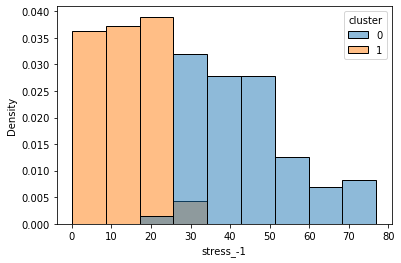

In [59]:
sns.histplot(data=df, x="stress_-1", hue="cluster", stat="density", common_norm=False)

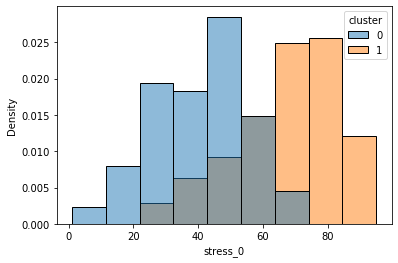

In [60]:
sns.histplot(data=df, x="stress_0", hue="cluster", stat="density", common_norm=False)

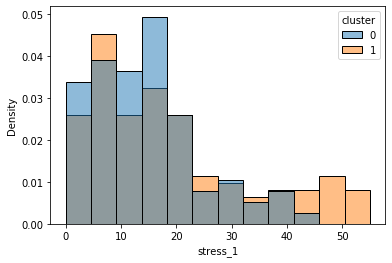

In [61]:
sns.histplot(data=df, x="stress_1", hue="cluster", stat="density", common_norm=False)

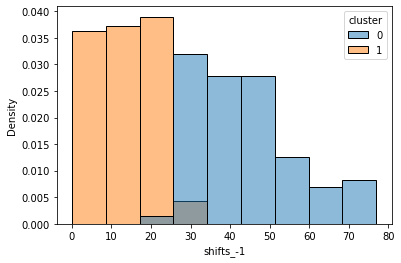

In [62]:
sns.histplot(data=df, x="shifts_-1", hue="cluster", stat="density", common_norm=False)

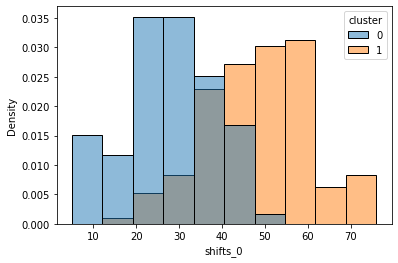

In [63]:
sns.histplot(data=df, x="shifts_0", hue="cluster", stat="density", common_norm=False)

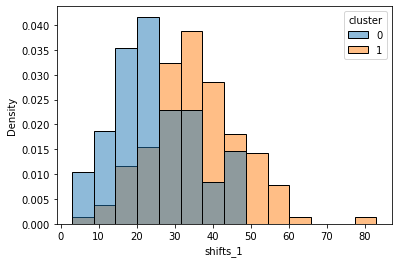

In [64]:
sns.histplot(data=df, x="shifts_1", hue="cluster", stat="density", common_norm=False)

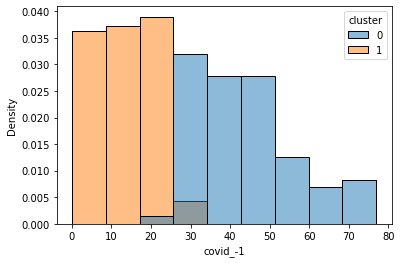

In [65]:
sns.histplot(data=df, x="covid_-1", hue="cluster", stat="density", common_norm=False)

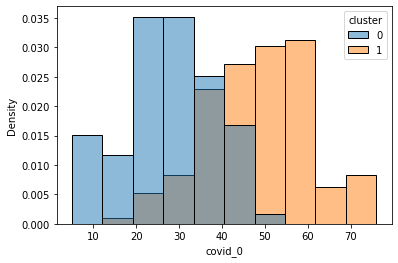

In [66]:
sns.histplot(data=df, x="covid_0", hue="cluster", stat="density", common_norm=False)

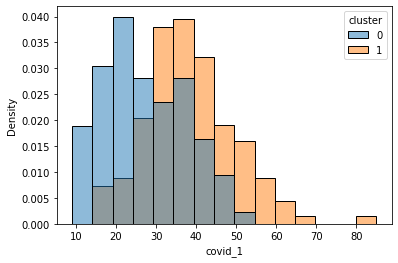

In [67]:
sns.histplot(data=df, x="covid_1", hue="cluster", stat="density", common_norm=False)

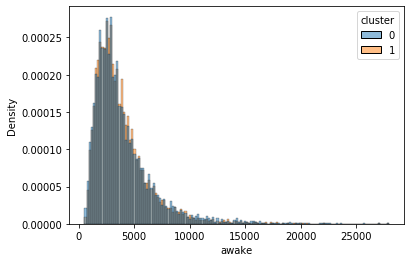

In [68]:
sns.histplot(data=sleep_df_subset, x="awake", hue="cluster", stat="density", common_norm=False)

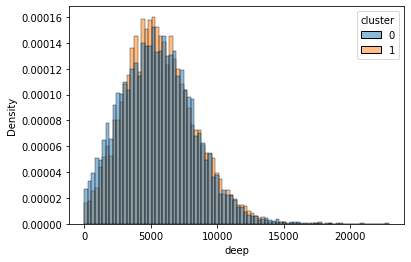

In [69]:
sns.histplot(data=sleep_df_subset, x="deep", hue="cluster", stat="density", common_norm=False)

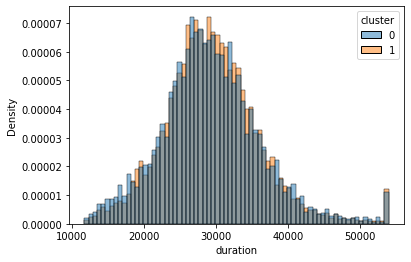

In [70]:
sns.histplot(data=sleep_df_subset, x="duration", hue="cluster", stat="density", common_norm=False)

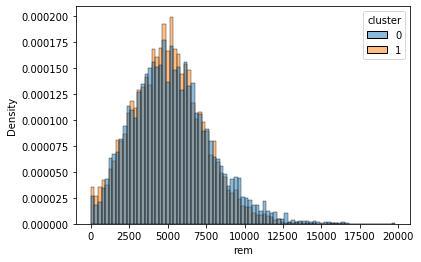

In [71]:
sns.histplot(data=sleep_df_subset, x="rem", hue="cluster", stat="density", common_norm=False)

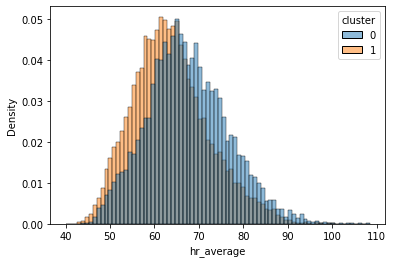

In [72]:
sns.histplot(data=sleep_df_subset, x="hr_average", hue="cluster", stat="density", common_norm=False)

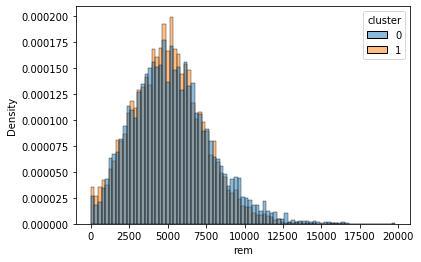

In [73]:
sns.histplot(data=sleep_df_subset, x="rem", hue="cluster", stat="density", common_norm=False)

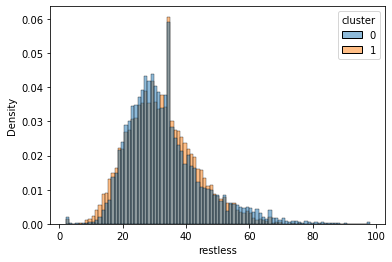

In [74]:
sns.histplot(data=sleep_df_subset, x="restless", hue="cluster", stat="density", common_norm=False)

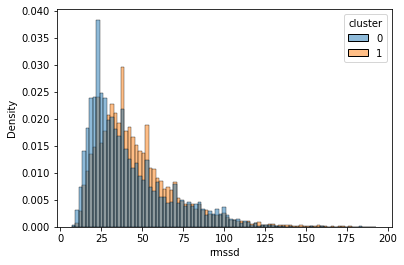

In [75]:
sns.histplot(data=sleep_df_subset, x="rmssd", hue="cluster", stat="density", common_norm = False)

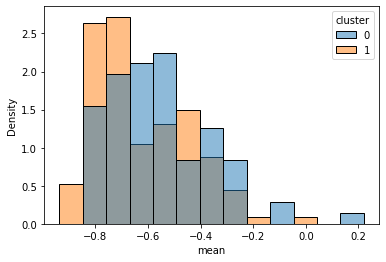

In [76]:
sns.histplot(data=pearson_grouped_subset, x="mean", hue="cluster", stat="density", common_norm=False)

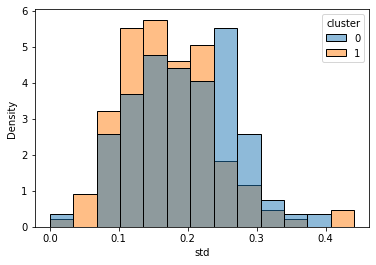

In [77]:
sns.histplot(data=pearson_grouped_subset, x="std", hue="cluster", stat="density", common_norm=False)

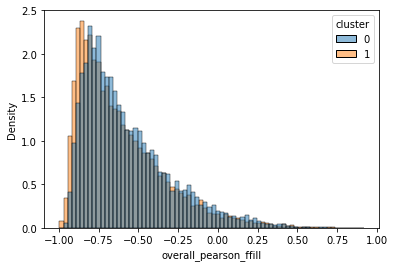

In [78]:
sns.histplot(data=pearson_individual_subset, x="overall_pearson_ffill", hue="cluster", stat="density", common_norm=False)

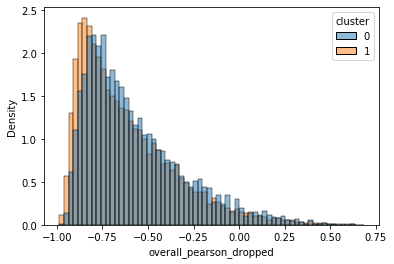

In [79]:
sns.histplot(data=pearson_individual_subset, x="overall_pearson_dropped", hue="cluster", stat="density", common_norm=False)

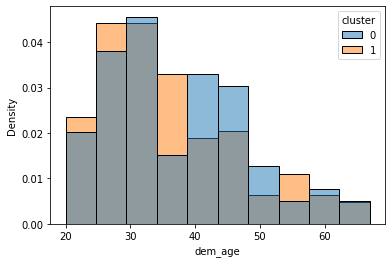

In [80]:
sns.histplot(data=once_merged_subset, x="dem_age", hue="cluster", stat="density", common_norm=False)

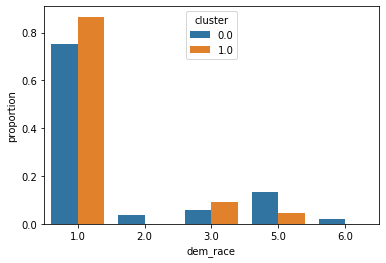

In [81]:
x, y, hue = "dem_race", "proportion", "cluster"
hue_order = [0,1]

(once_merged_subset[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

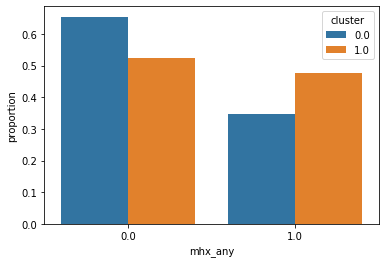

In [82]:
x, y, hue = "mhx_any", "proportion", "cluster"
hue_order = [0,1]

(once_merged_subset[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

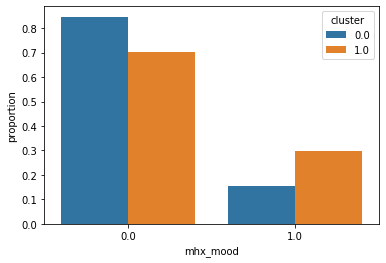

In [83]:
x, y, hue = "mhx_mood", "proportion", "cluster"
hue_order = [0,1]

(once_merged_subset[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

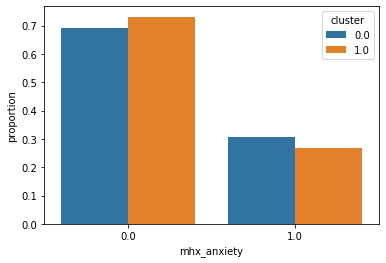

In [84]:
x, y, hue = "mhx_anxiety", "proportion", "cluster"
hue_order = [0,1]

(once_merged_subset[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))